In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import scipy.fft as fft
import scipy.signal as signal
from sklearn.pipeline import Pipeline
from pprint import pprint
from datetime import datetime
from scipy.signal import find_peaks
import pywt
from scipy import stats
import matplotlib.mlab as mlab

## Discrete Fourier Transform

The Discrete Fourier Transform (DFT) converts a finite sequence sample of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier Transform (a complex-valued function of the frequency). The main relevant assumption is that the original function is equally spaced itself. 

$X_k = \sum_{n=0}^{N-1}x_n\cdot e^{-i2\pi \frac{k}{N}n}$

The Fast Fourier Transform (FFT) is a power algorithm to compute the DFT (and its inverse) that runs in $O(n \log n)$, providing a great computational advantage over the $O(n^2)$ of the naive implementation. 

We performed the FFT over all relevant pricipal components to investigate the frequency spectrum.

We can clearly see two peaks:
* First peak: around $0.2$ Hz (i.e. $12$ BPM), it refers to the respiratory rate. 
* Second peak: around $1.2$ Hz (i.e. $72$ BPM), it's related to the heart rate, our feature of interest. In an healthy adult at rest, the typical beat rate is between $40$ and $100$ BPM. 

We can also notice some high-frequency noise that could interfere with our analysis. 

In [23]:
# Get the most relevant principal components
data_after_pca_only_most_important_feature = data_after_pca[:,0:most_important_features_number]
N = len(data_after_pca)

# Perform the DFT
sig_fft = fft.fftshift(fft.fft(data_after_pca_only_most_important_feature, axis=0))
frequencies = fft.fftshift(fft.fftfreq(N, d=1/mean_frequency))

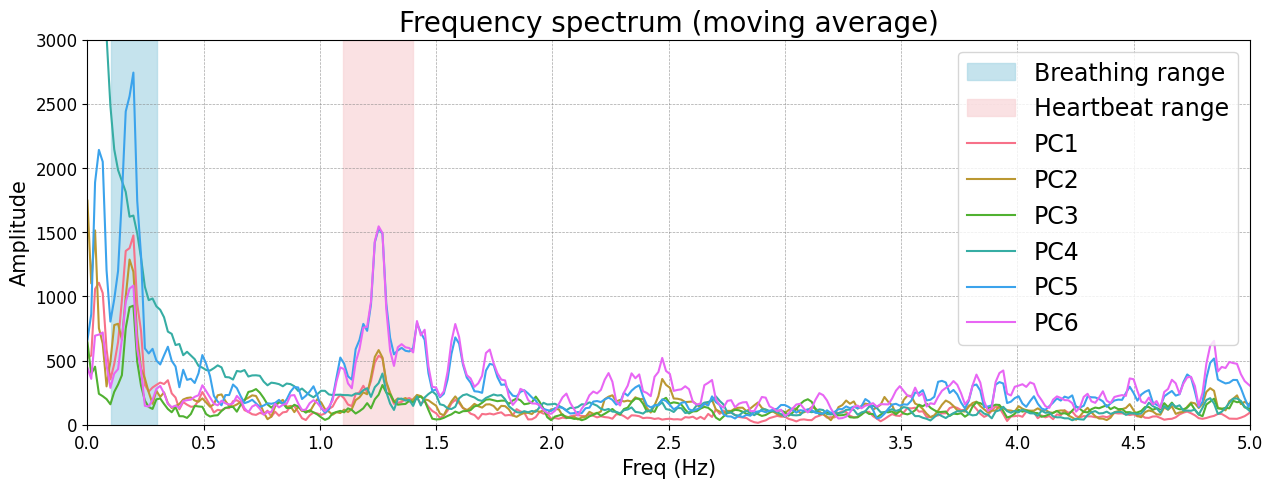

In [24]:
# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

ax.axvspan(0.1, 0.3, color="lightblue", alpha=0.7, label="Breathing range")
ax.axvspan(1.1, 1.4, color="#F8D5D8", alpha=0.7, label="Heartbeat range")

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.xaxis.set_ticks(np.arange(0, 10, 0.5))
ax.set_xlim(0, 5)
ax.set_ylim(-0.5, 3000)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average)", fontsize=20)
ax.legend(fontsize=17, loc="upper right")

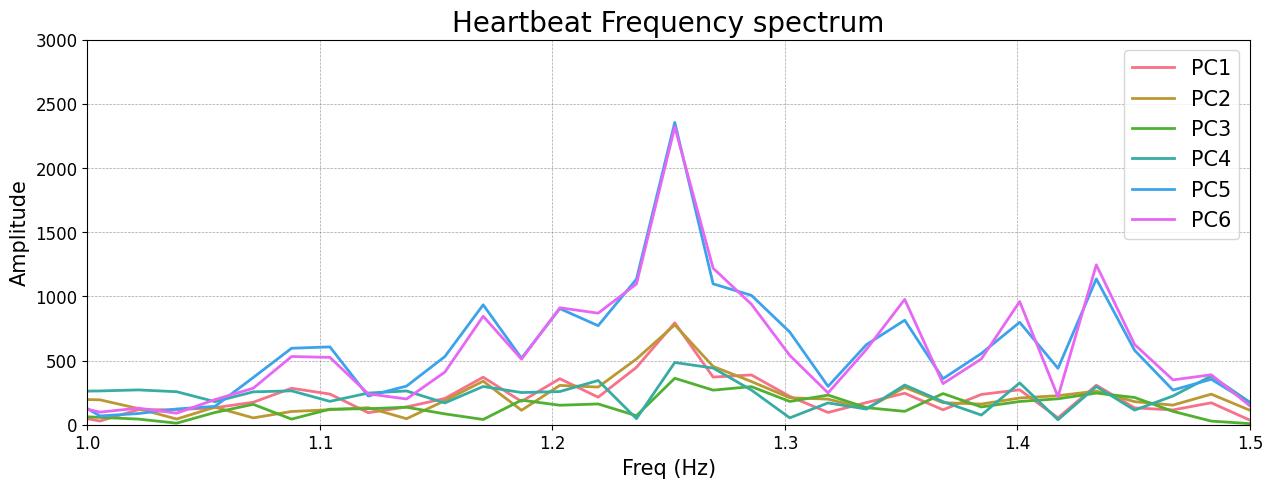

In [25]:
# Plot relevant frequency band
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies, np.abs(sig_fft[:, i]), lw=2, color=color, label="PC"+str(i+1))

ax.set_xlim(1.0, 1.5)
ax.set_ylim(-0.5, 3000)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Heartbeat Frequency spectrum", fontsize=20)
ax.legend(fontsize=15)

## Filters

### Filter on the spectrum

To isolate the frequencies we are interesting in, we made a bandpass filter between $1.1$ and $1.4$ Hz. This means to filtered out most of the unwanted frequencies, but some noise is mantained. 

By antitrasforming the data, we can obtain a periodical time-series. Its frequency is an estimate of hearth rate itself. 

It is important to notice that the DTF integrate the temporal information, so it's a steady procedure and the temporal variabily of its inverse refers to the noisy spectrum. 

In [26]:
# Filter the spectrum
filtered_sig_fft = sig_fft.copy()
filtered_sig_fft[(np.abs(frequencies) < 1.1) | (np.abs(frequencies) > 1.4)] = 0

# Antitrasformed the spectrum
inversed_sig_fft = np.fft.ifft(np.fft.ifftshift(filtered_sig_fft), axis=0)

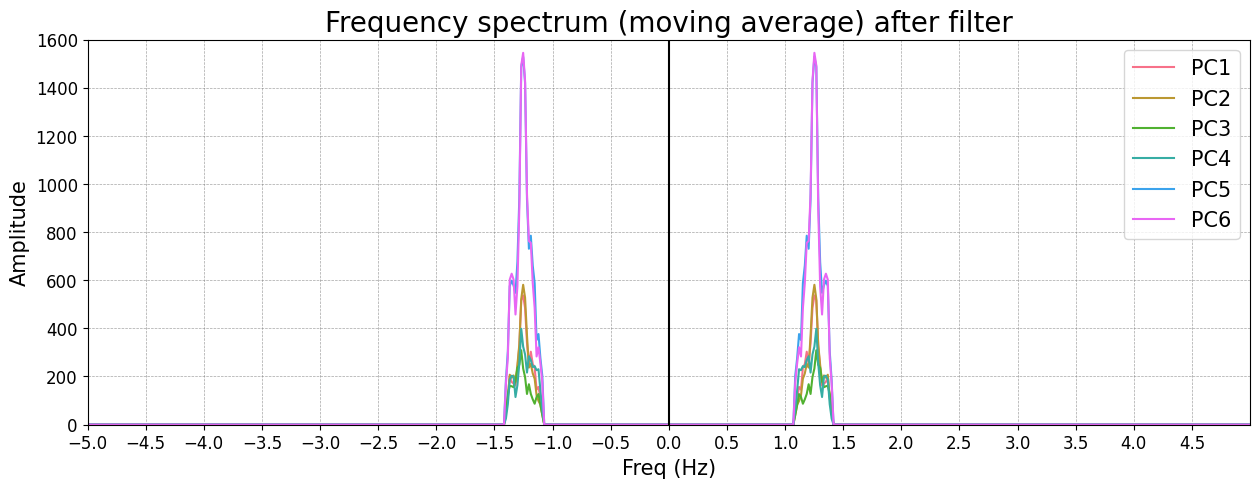

In [27]:
# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(filtered_sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.set_xlim(-5, 5)
ax.set_ylim(-0.5, 1600)
ax.xaxis.set_ticks(np.arange(-5, 5, 0.5))
ax.vlines(0, -0.5, 1600, color="black")
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average) after filter", fontsize=20)
ax.legend(fontsize=15)

Text(0, 0.5, 'Amplitude')

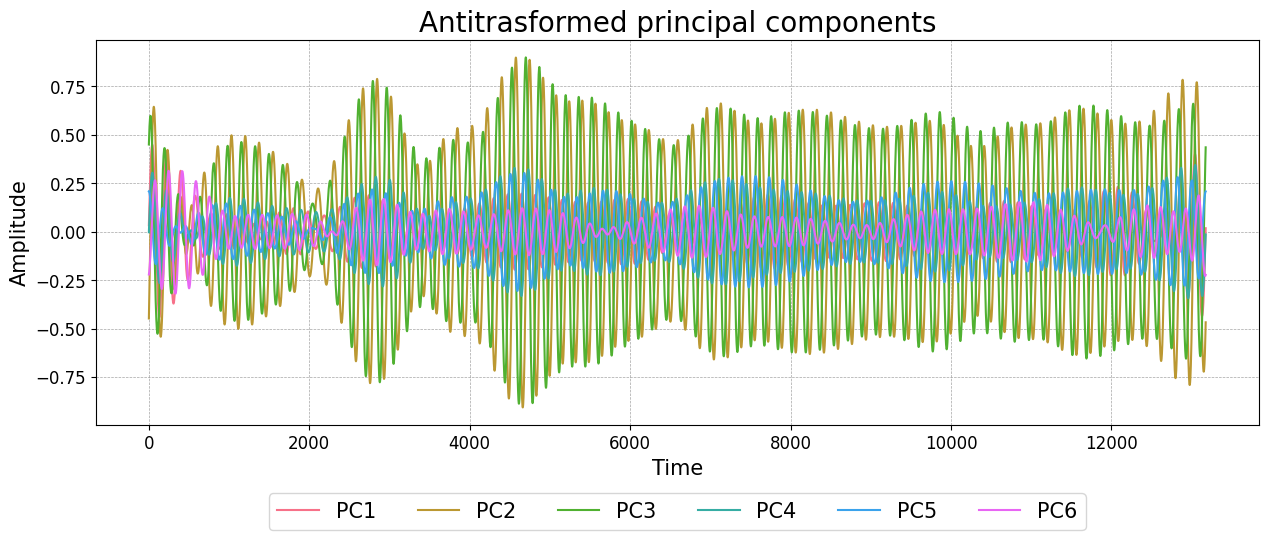

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(np.arange(len(inversed_sig_fft.real[:, i])), inversed_sig_fft.real[:, i], color=color, label="PC"+str(i+1))

ax.set_title("Antitrasformed principal components", fontsize=20)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncols = most_important_features_number, fontsize=15)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)

**PEAKS ANALYSYS BY JACOPO'S FUNCTION**

### Gaussian filter

As we said, the Fourier spectrum is noisy. One idea is to fit the data and to antitrasform the resulting function. Since we expect a single frequency, it would be reasonable to perform a Gaussian fit of the spectrum. 

The main limitation of this procedure is that the is that in that region of the spectrum there are only few points and the fitting procedure is unprecise. 

In [32]:
from scipy.optimize import curve_fit
gauss = lambda x, A, mu, sigma : A**2/sigma/np.sqrt(2*np.pi)*np.exp(-0.5*((x-mu)/sigma)**2)

In [33]:
# Fit the Gaussian functions
fits = [curve_fit(gauss, frequencies, filtered_sig_fft[:, i].real, p0=[12, 1.25, 0.03]) for i in range(most_important_features_number)]
print("Amplitude: " + str([fits[i][0][0] for i in range(most_important_features_number)]))
print("Peaks: " + str([fits[i][0][1] for i in range(most_important_features_number)]))
print("Standard deviations: " + str([fits[i][0][2] for i in range(most_important_features_number)]))

Amplitude: [4.8359899268979145, 3.5265004069444346, -5.088664408773379, 3.037542947761021, 4.433307807363669, 10.605787812865483]
Peaks: [1.2465807827025142, 1.2304550002867638, 1.3098752373289313, 1.1964580479408924, 1.2747260959573532, 1.244875706844592]
Standard deviations: [0.0039779402540784815, 0.004214056758783106, -0.05127629315371478, 0.0185853912982303, 0.020722548633074614, 0.0039916389037182465]


Text(0.5, 1.0, 'Gaussian fits of the frequency spectrum')

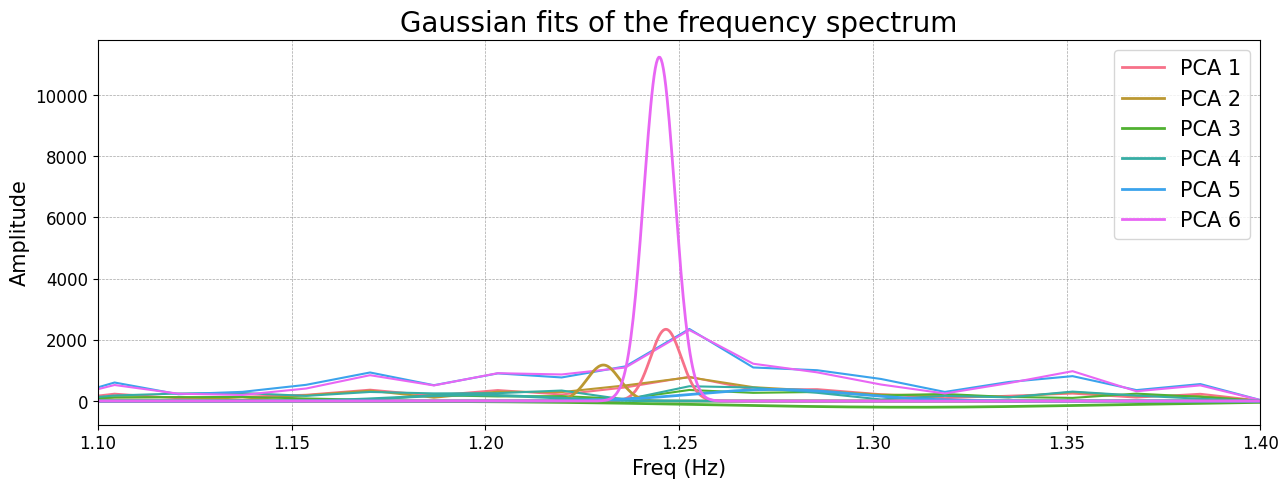

In [43]:
# Plot relevant frequency band
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies, np.abs(filtered_sig_fft[:, i]), 3, color=color)

lin = np.linspace(1.1, 1.4, 1000)
for i, color in zip(pca_indeces, palette):
    ax.plot(lin, gauss(lin, fits[i][0][0], fits[i][0][1], fits[i][0][2]), lw=2, label="PCA " + str(i+1), color=color)

ax.legend(loc="upper right", fontsize=15)
ax.set_xlim(1.1, 1.4)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Gaussian fits of the frequency spectrum", fontsize=20)

Text(0.5, 1.0, 'Gaussian spectrum (PCA 6)')

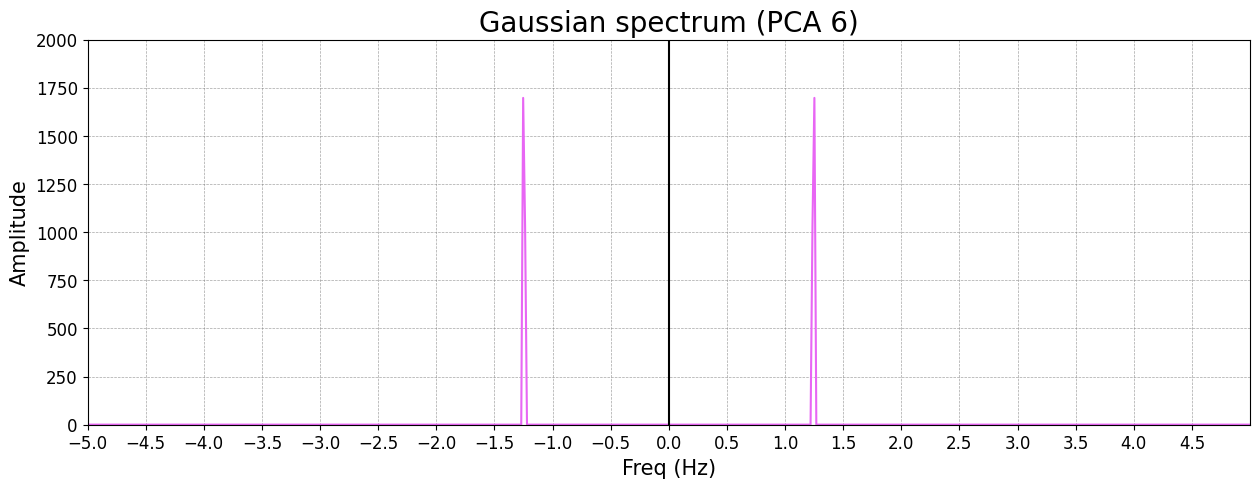

In [35]:
# Keep the gaussian referring to PCA 6
double_gauss = lambda x, A, mu, sigma: gauss(x, A, mu, sigma) + gauss(x, A, -mu, sigma)

param = fits[5][0]
gaussian_spectrum = double_gauss(frequencies, param[0], param[1], param[2])


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

ax.plot(frequencies, gaussian_spectrum, color=palette[5])

ax.set_xlim(-5, 5)
ax.set_ylim(-0.5, 2000)
ax.xaxis.set_ticks(np.arange(-5, 5, 0.5))
ax.vlines(0, -0.5, 2000, color="black")
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Gaussian spectrum (PCA 6)", fontsize=20)

**PEAKS ANALYSYS BY JACOPO'S FUNCTION**

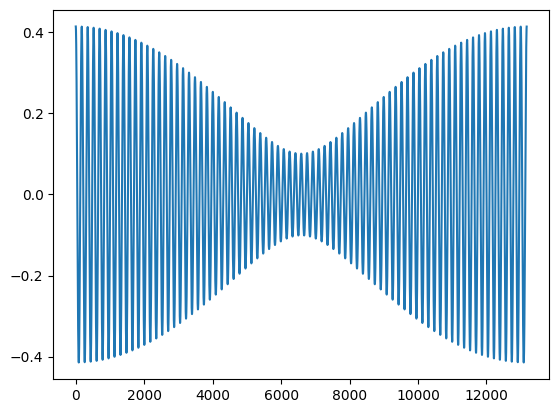

In [37]:
# Plot just as a reference
inversed_sig_fft = np.fft.ifft(np.fft.ifftshift(gaussian_spectrum), axis=0)
plt.plot(inversed_sig_fft.real)

#### WAVELET

A powerful alternative to the DFT is the *wavelet transform*, which overcomes the loss of the temporal information. 

In this project, we used a *Daubechies 6* wavelet. [The literature](https://www.sciencedirect.com/science/article/pii/S174680941930360X?via%3Dihub) suggests this wavelet because of its smooth shape and its similarity to the oscillating pattern of the heartbeat. 

The signal is iteratively divided into the low and high frequency components for $J$ levels. The net result is the list of coefficients $[A_J, \{D_j\}_j]$ with $1 \le j \le J$. Being $f_s$ the original frequency, $A_J$ refers to the frequencies between $0$ and $f_s/2^{J+1}$ while each $D_j$ coefficient refers to the $[f_s/2^{j+1}, f_s/2^{j}]$ range. Our ``get_frequency_ranges()`` function returns the ranges depending on $f_s$ and the used level.

The main limitation of this method is that you cannot choose the frequency range, because of the given discretization. 

We expect the normal beat to be between $[0.67, 1.67]$ Hz. Thus, the coefficient we need is the fifth (frequences between $[0.84, 1.70]$ Hz).


In [38]:
# Perform the multilevel decomposition of the time series
max_level = pywt.dwt_max_level(len(data_after_pca_only_most_important_feature), "db6")
print("Maximum useful level of decomposition for this dataset: " + str(max_level))

coeffs = pywt.wavedec(data_after_pca_only_most_important_feature, "db6", level=max_level, axis=0)

Maximum useful level of decomposition for this dataset: 10


In [39]:
# Helper function to compute the frequency ranges of a wavelet decomposition
def get_frequency_ranges(f_s, level):
    freq = [[0, f_s/2**(level+1)]]

    for j in range(level, 0, -1):
        freq.append([f_s/2**(j+1), f_s/2**(j)])

    return freq

get_frequency_ranges(mean_frequency, max_level)

[[0, 0.10604697779605263],
 [0.10604697779605263, 0.21209395559210525],
 [0.21209395559210525, 0.4241879111842105],
 [0.4241879111842105, 0.848375822368421],
 [0.848375822368421, 1.696751644736842],
 [1.696751644736842, 3.393503289473684],
 [3.393503289473684, 6.787006578947368],
 [6.787006578947368, 13.574013157894736],
 [13.574013157894736, 27.148026315789473],
 [27.148026315789473, 54.296052631578945],
 [54.296052631578945, 108.59210526315789]]

We expect the normal beat to be between $[0.67, 1.67] Hz$. The coefficient we need is the fifth (frequences between $[0.78, 1.56]Hz$). We are cutting some boundary frequences.  

In [40]:
# Function to set to zero the unwanted coefficients
def select_coeffs(coeffs, useful_coeffs):
    assert type([0, 1]) == list, "useful_coeffs must be a list"

    for i in range(len(coeffs)):
        if i not in useful_coeffs:
            #Replace with a zero array of the same size
            coeffs[i] = np.zeros_like(coeffs[i])
    
    return coeffs

filtered_coeff = select_coeffs(coeffs, [4])

In [41]:
# Wavelet antitransform
filtered_sig = pywt.waverec(filtered_coeff, "db6", axis=0)

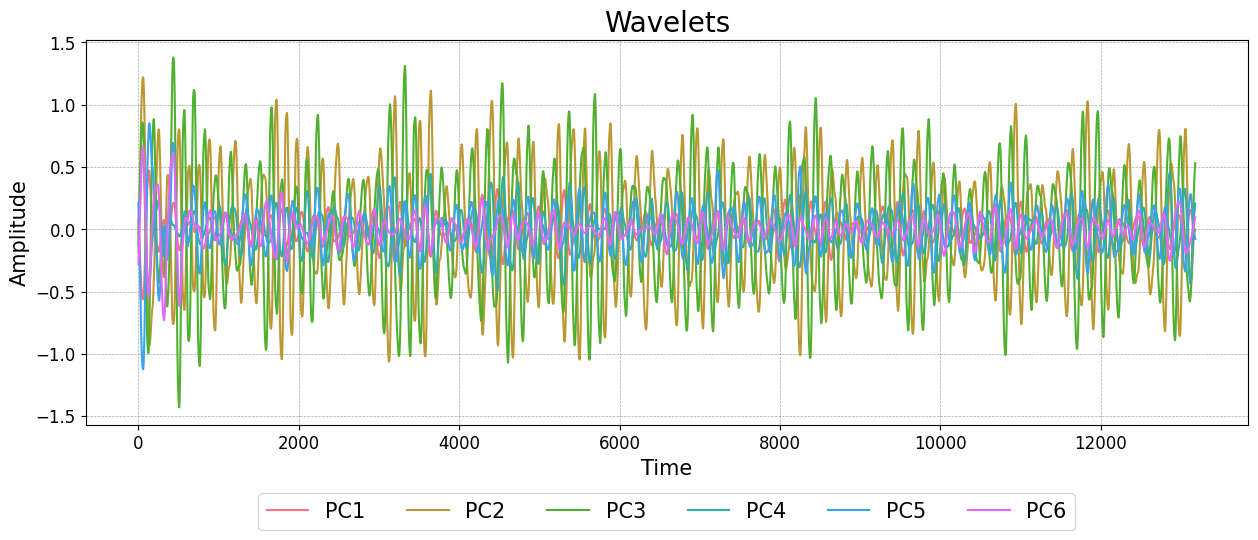

In [42]:
# Plot the wavelet transform of the principal components
fig, ax = plt.subplots(figsize=(15, 5))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

pca_indeces = np.arange(most_important_features_number)
palette = sns.color_palette("husl", most_important_features_number)
assert len(pca_indeces) == len(palette), "Size error"

for i, color in zip(pca_indeces, palette):
    ax.plot(filtered_sig[:, i], color=color, label="PC"+str(i+1))

ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Wavelets", fontsize=20)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncols = most_important_features_number, fontsize=15)


**PEAKS ANALYSYS BY JACOPO'S FUNCTION**